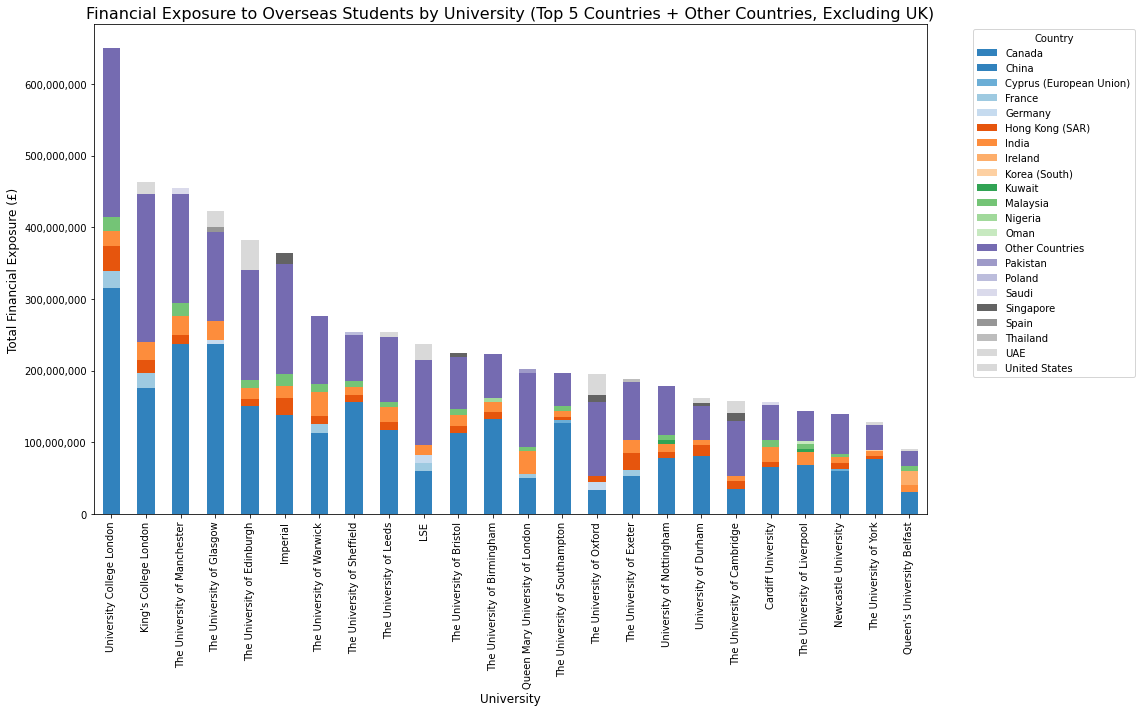

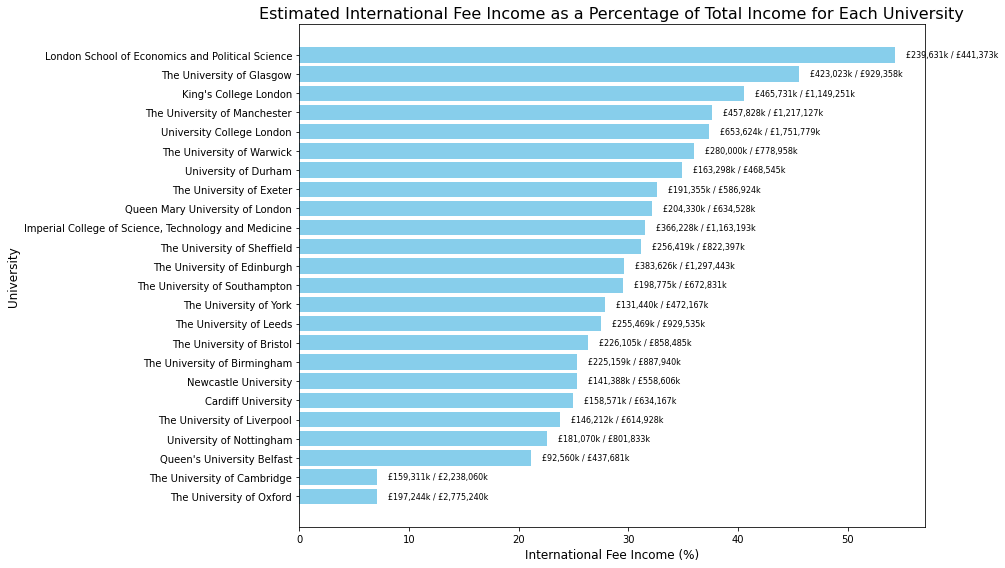

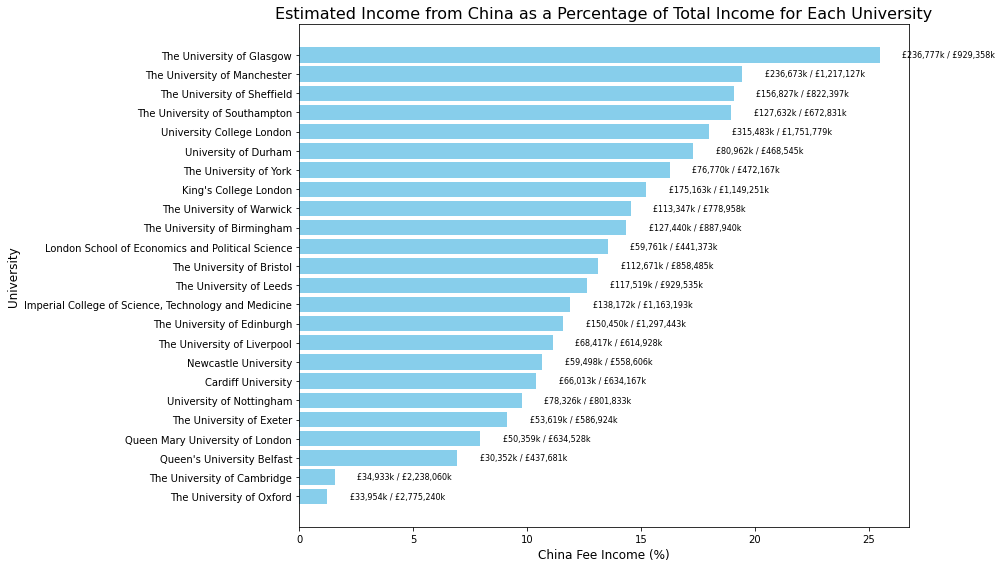

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

def load_and_clean_data(fee_data_path, student_data_path):
    
    fee_data = pd.read_csv(fee_data_path)
    
    # Clean the fee data: remove special characters and convert fees to numerical values
    fee_data['Fee'] = fee_data[' Fee'].str.replace('[£,]', '', regex=True).apply(pd.to_numeric, errors='coerce')
    
    # Select necessary columns
    fee_data = fee_data[['University name - HESA', 'Fee', 'UG/PG']]
    
    # Calculate average fees for each university and each study type (UG/PG)
    avg_fees = fee_data.groupby(['University name - HESA', 'UG/PG'])['Fee'].mean().unstack()
    
    # Estimate the average PG part-time fee as 50% of the full-time PG fee
    avg_fees['Fee_PG_PT'] = avg_fees['PG'] * 0.5
    
    # Summarise the average fees by university (one row per university)
    avg_fees = avg_fees.reset_index()

    # Load the student population data from the provided CSV file
    student_data = pd.read_csv(student_data_path)
    
    # Correct the filtering for student data: strip whitespace from university and country names
    student_data['University'] = student_data['HE Provider'].str.strip()
    student_data['Country'] = student_data['Country'].str.strip()
    
    # Merge the student data with the average fee data
    merged_data = student_data.merge(avg_fees, left_on='University', right_on='University name - HESA', how='left')
    
    # Calculate the financial exposure based on the relevant level and mode of study
    merged_data['Financial Exposure'] = 0
    merged_data.loc[merged_data['Level of study'] == 'All undergraduate', 'Financial Exposure'] = merged_data['Headcount'] * merged_data['UG']
    merged_data.loc[(merged_data['Level of study'] == 'Postgraduate (taught)') & (merged_data['Mode of study'] == 'Full-time'), 'Financial Exposure'] = merged_data['Headcount'] * merged_data['PG']
    merged_data.loc[(merged_data['Level of study'] == 'Postgraduate (taught)') & (merged_data['Mode of study'] == 'Part-time'), 'Financial Exposure'] = merged_data['Headcount'] * merged_data['Fee_PG_PT']
    
    merged_data.to_csv('merged_data_01.csv')
    
   # Summarize the financial exposure by university and country
    financial_exposure_summary = merged_data.groupby(['University', 'Country'])['Financial Exposure'].sum().reset_index()
    
    return financial_exposure_summary

def visualize_universities_exposure(financial_exposure_summary):
    # Exclude the UK and 'International not otherwise specified' from the analysis
    financial_exposure_summary = financial_exposure_summary[financial_exposure_summary['Country'].str.lower() != 'uk']
    financial_exposure_summary = financial_exposure_summary[financial_exposure_summary['Country'] != 'International not otherwise specified']
    
    # Shorten long country names
    country_name_replacements = {
        'Trinidad and Tobago': 'Trinidad & Tobago',
        'United Arab Emirates': 'UAE',
        'United States of America': 'USA',
        'Saudi Arabia': 'Saudi',
        'China (Mainland)': 'China',
        'Hong Kong (Special Administrative Region of China)': 'Hong Kong (SAR)'
    }
    
    # Apply the replacements to the country names
    financial_exposure_summary['Country'] = financial_exposure_summary['Country'].replace(country_name_replacements)
    
    # Shorten specific university names
    university_name_replacements = {
        'London School of Economics and Political Science': 'LSE',
        'Imperial College of Science, Technology and Medicine': 'Imperial'
    }
    
    # Apply the replacements to the university names
    financial_exposure_summary['University'] = financial_exposure_summary['University'].replace(university_name_replacements)
    
    # save merged data
    financial_exposure_summary.to_csv('merged_data.csv')
    
    # Rank the countries by financial exposure for each university and select the top 5
    financial_exposure_summary['rank'] = financial_exposure_summary.groupby('University')['Financial Exposure'].rank(method='first', ascending=False)
    top_countries = financial_exposure_summary[financial_exposure_summary['rank'] <= 5]
    
    # Identify the other countries
    other_countries = financial_exposure_summary[financial_exposure_summary['rank'] > 5]
    
    # Aggregate the financial exposure of other countries
    other_countries_agg = other_countries.groupby('University')['Financial Exposure'].sum().reset_index()
    other_countries_agg['Country'] = 'Other Countries'
    
    # Combine the top countries and other countries
    combined_data = pd.concat([top_countries, other_countries_agg], ignore_index=True)
    
    # Pivot the data to get it in the right format for plotting
    pivot_data = combined_data.pivot_table(index='University', columns='Country', values='Financial Exposure', aggfunc='sum', fill_value=0)
    
    # Sort the universities by total financial exposure
    pivot_data['Total'] = pivot_data.sum(axis=1)
    pivot_data = pivot_data.sort_values(by='Total', ascending=False).drop(columns='Total')
    
    # Create a stacked bar chart to visualise the financial exposure by university
    fig, ax = plt.subplots(figsize=(16, 10))
    
    # Plot the data
    pivot_data.plot(kind='bar', stacked=True, ax=ax, colormap='tab20c')
    
    # titles and axes
    ax.set_title('Financial Exposure to Overseas Students by University (Top 5 Countries + Other Countries, Excluding UK)', fontsize=16)
    ax.set_xlabel('University', fontsize=12)
    ax.set_ylabel('Total Financial Exposure (£)', fontsize=12)
    ax.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    ax.ticklabel_format(style='plain', axis='y')  # Disable scientific notation for y axis
    ax.get_yaxis().set_major_formatter(plt.matplotlib.ticker.FuncFormatter(lambda x, p: f'{x:,.0f}'))  # Add commas to y-axis
    
    plt.xticks(rotation=90, fontsize=10)
    plt.tight_layout()
    
    # Display the plot
    plt.show()

def visualize_income_percentage(financial_exposure_summary, income_data_path):
    
    income_data = pd.read_csv(income_data_path)
    
    # Convert relevant columns to numeric values for calculation
    income_columns = [
        'Tuition fees and education contracts income',
        'Funding body grants income',
        'Research grants and contracts income',
        'Other income',
        'Investment income',
        'Donations and endowments income'
    ]
    
    for column in income_columns:
        income_data[column] = income_data[column].astype(str).str.replace(',', '').astype(float)
    
    # Calculate the total income for each university
    income_data['Total Income'] = (
        income_data['Tuition fees and education contracts income'] +
        income_data['Funding body grants income'] +
        income_data['Research grants and contracts income'] +
        income_data['Other income'] +
        income_data['Investment income'] +
        income_data['Donations and endowments income']
    )
    
    # Drop rows where the country is 'UK'
    financial_exposure_summary = financial_exposure_summary[financial_exposure_summary['Country'].str.lower() != 'uk']
    
    # Drop the 'Country' column
    financial_exposure_summary = financial_exposure_summary.drop(columns='Country')
    
    # Summarise the financial exposure data by university
    summarized_financial_exposure = financial_exposure_summary.groupby('University')['Financial Exposure'].sum().reset_index()
    
    # Merge the financial exposure data with the income data
    merged_income_data = summarized_financial_exposure.merge(income_data, left_on='University', right_on='HE Provider', how='left')
    
    # Calculate the estimated international fee income as a percentage of total income for each university
    merged_income_data['International Fee Income %'] = (merged_income_data['Financial Exposure'] / merged_income_data['Total Income']) * 100
    
    # Group by university and calculate the total percentage
    international_fee_income_percentage = merged_income_data.groupby('University')['International Fee Income %'].sum().reset_index()
    
    # Sort by the highest percentage
    international_fee_income_percentage = international_fee_income_percentage.sort_values(by='International Fee Income %', ascending=False)
    
    # Create a horizontal bar chart to visualise the estimated international fee income as a percentage of total income for each university
    fig, ax = plt.subplots(figsize=(14, 8))
    bars = ax.barh(international_fee_income_percentage['University'], international_fee_income_percentage['International Fee Income %'], color='skyblue')
    
    # Add data labels to the bars
    for bar in bars:
        width = bar.get_width()
        label_x_pos = width + 1
        university = international_fee_income_percentage['University'].iloc[int(bar.get_y() + bar.get_height() / 2)]
        total_income = merged_income_data.loc[merged_income_data['University'] == university, 'Total Income'].values[0] / 1000  # In thousands
        exposure = merged_income_data.loc[merged_income_data['University'] == university, 'Financial Exposure'].values[0] / 1000  # In thousands
        plt.text(label_x_pos, bar.get_y() + bar.get_height() / 2, f'£{exposure:,.0f}k / £{total_income:,.0f}k', va='center', ha='left', fontsize=8)
    
    # titles and axes
    ax.set_title('Estimated International Fee Income as a Percentage of Total Income for Each University', fontsize=16)
    ax.set_xlabel('International Fee Income (%)', fontsize=12)
    ax.set_ylabel('University', fontsize=12)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    
    # Display the plot
    plt.show()

def visualize_china_income_percentage(financial_exposure_summary, income_data_path):
    
    income_data = pd.read_csv(income_data_path)
    
    # Convert columns to numeric for calculation
    income_columns = [
        'Tuition fees and education contracts income',
        'Funding body grants income',
        'Research grants and contracts income',
        'Other income',
        'Investment income',
        'Donations and endowments income'
    ]
    
    # remove commas from data
    for column in income_columns:
        income_data[column] = income_data[column].astype(str).str.replace(',', '').astype(float)
    
    # Calculate the total income for each university
    income_data['Total Income'] = (
        income_data['Tuition fees and education contracts income'] +
        income_data['Funding body grants income'] +
        income_data['Research grants and contracts income'] +
        income_data['Other income'] +
        income_data['Investment income'] +
        income_data['Donations and endowments income']
    )
    
    # Filter financial exposure summary to include only China
    china_exposure_summary = financial_exposure_summary[financial_exposure_summary['Country'] == 'China']
    
    # Summarise the financial exposure data by university for China
    summarized_china_exposure = china_exposure_summary.groupby('University')['Financial Exposure'].sum().reset_index()
    
    # Merge the financial exposure data with the income data
    merged_china_income_data = summarized_china_exposure.merge(income_data, left_on='University', right_on='HE Provider', how='left')
    
    # Calculate the estimated China fee income as a percentage of total income for each university
    merged_china_income_data['China Fee Income %'] = (merged_china_income_data['Financial Exposure'] / merged_china_income_data['Total Income']) * 100
    
    # Group by university and calculate the total percentage
    china_fee_income_percentage = merged_china_income_data.groupby('University')['China Fee Income %'].sum().reset_index()
    
    # Sort by the highest percentage
    china_fee_income_percentage = china_fee_income_percentage.sort_values(by='China Fee Income %', ascending=False)
    
    # Create a horizontal bar chart to visualise the estimated China fee income as a percentage of total income for each university
    fig, ax = plt.subplots(figsize=(14, 8))
    bars = ax.barh(china_fee_income_percentage['University'], china_fee_income_percentage['China Fee Income %'], color='skyblue')
    
    # Add data labels to the bars
    for bar in bars:
        width = bar.get_width()
        label_x_pos = width + 1
        university = china_fee_income_percentage['University'].iloc[int(bar.get_y() + bar.get_height() / 2)]
        total_income = merged_china_income_data.loc[merged_china_income_data['University'] == university, 'Total Income'].values[0] / 1000  # In thousands
        exposure = merged_china_income_data.loc[merged_china_income_data['University'] == university, 'Financial Exposure'].values[0] / 1000  # In thousands
        plt.text(label_x_pos, bar.get_y() + bar.get_height() / 2, f'£{exposure:,.0f}k / £{total_income:,.0f}k', va='center', ha='left', fontsize=8)
    
    # titles and axes
    ax.set_title('Estimated Income from China as a Percentage of Total Income for Each University', fontsize=16)
    ax.set_xlabel('China Fee Income (%)', fontsize=12)
    ax.set_ylabel('University', fontsize=12)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    
    # Display the plot
    plt.show()

if __name__ == '__main__':
    # File paths to the fee data, student data, and income data CSV files
    fee_data_path = 'Fee data.csv'
    student_data_path = 'Students by country.csv'
    income_data_path = 'income data.csv'
    
    # Load and clean the data
    financial_exposure_summary = load_and_clean_data(fee_data_path, student_data_path)
    
    # Visualise the financial exposure for universities
    visualize_universities_exposure(financial_exposure_summary)
    
    # Visualise the estimated international fee income as a percentage of total income for each university
    visualize_income_percentage(financial_exposure_summary, income_data_path)
    
    # Visualise the estimated income from China as a percentage of total income for each university
    visualize_china_income_percentage(financial_exposure_summary, income_data_path)
